In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 7,  9,  5, 10,  4,  2,  6,  8,  1]), tensor([3, 0]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) #인자는 입력 크기와 출력 크기이며 편향값은 기본인 True이다.
linear_model(t_un_val)

tensor([[-0.9806],
        [-0.5428]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.0948]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.2045], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.2993], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.2993],
        [-0.2993],
        [-0.2993],
        [-0.2993],
        [-0.2993],
        [-0.2993],
        [-0.2993],
        [-0.2993],
        [-0.2993],
        [-0.2993]], grad_fn=<AddmmBackward0>)

## 배치 최적화

In [10]:
linear_model = nn.Linear(1, 1) #앞서 나온 내용을 다시 정의
optimizer = optim.SGD(
    linear_model.parameters(), #[params] 부분 대신 넣은 것
    lr=1e-2)

전에는 파라미터를 직접 만들고 optim.SGD의 첫 번째 인자로 전달해야 했다. 이제는 nn.Module이나 어떤 하위 모듈에 대해서도 parameters 메소드로 파라미터 리스트를 얻을 수 있다.

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x7fb590ca7e60>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.7702]], requires_grad=True),
 Parameter containing:
 tensor([-0.9783], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # 개별 파라미터 대신 모델이 전달됐다.
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # 개별 파라미터 대신 모델이 전달됐다.
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # 손실 함수도 전달됐다. 곧 사용할 예정이다.
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) 
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 206.1983, Validation loss 514.0997
Epoch 1000, Training loss 4.1191, Validation loss 16.8391
Epoch 2000, Training loss 2.9996, Validation loss 7.5557
Epoch 3000, Training loss 2.9176, Validation loss 5.6759

Parameter containing:
tensor([[4.9319]], requires_grad=True)
Parameter containing:
tensor([-15.0932], requires_grad=True)


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # 이제 직접 만든 손실 함수는 사용하지 않는다.
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 197.6410, Validation loss 510.1282
Epoch 1000, Training loss 4.2842, Validation loss 17.8634
Epoch 2000, Training loss 3.0117, Validation loss 7.7396
Epoch 3000, Training loss 2.9185, Validation loss 5.7188

Parameter containing:
tensor([[4.9281]], requires_grad=True)
Parameter containing:
tensor([-15.0727], requires_grad=True)


## 선형 모델 대체하기

손실 함수를 포함한 나머지 모든 것은 그대로 두고 model만 다시 정의한다.

In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # 이전과 다른 텐서 형태를 가지려고 임의로 13을 골랐다.
            nn.Tanh(),
            nn.Linear(13, 1)) # 다만 여기서는 앞의 13과 일치해야 한다.
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
#파라미터 살펴보기
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.3009], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 140.7903, Validation loss 390.3886
Epoch 1000, Training loss 5.8478, Validation loss 61.4504
Epoch 2000, Training loss 3.0947, Validation loss 28.0343
Epoch 3000, Training loss 2.5154, Validation loss 18.1717
Epoch 4000, Training loss 2.6441, Validation loss 14.6504
Epoch 5000, Training loss 2.3623, Validation loss 11.9644
output tensor([[23.8531],
        [ 2.4945]], grad_fn=<AddmmBackward0>)
answer tensor([[28.0000],
        [ 0.5000]])
hidden tensor([[-1.2434e+00],
        [-2.5904e+01],
        [ 2.0304e+01],
        [-5.3995e-03],
        [ 1.8602e+00],
        [-9.3915e+00],
        [-6.2835e-01],
        [ 8.7928e-03]])


## 선형 모델과 비교하기

이제 모든 데이터에 대한 우리의 모델이 단순 선형과 어떤 차이가 있는지 평가할 수 있다.

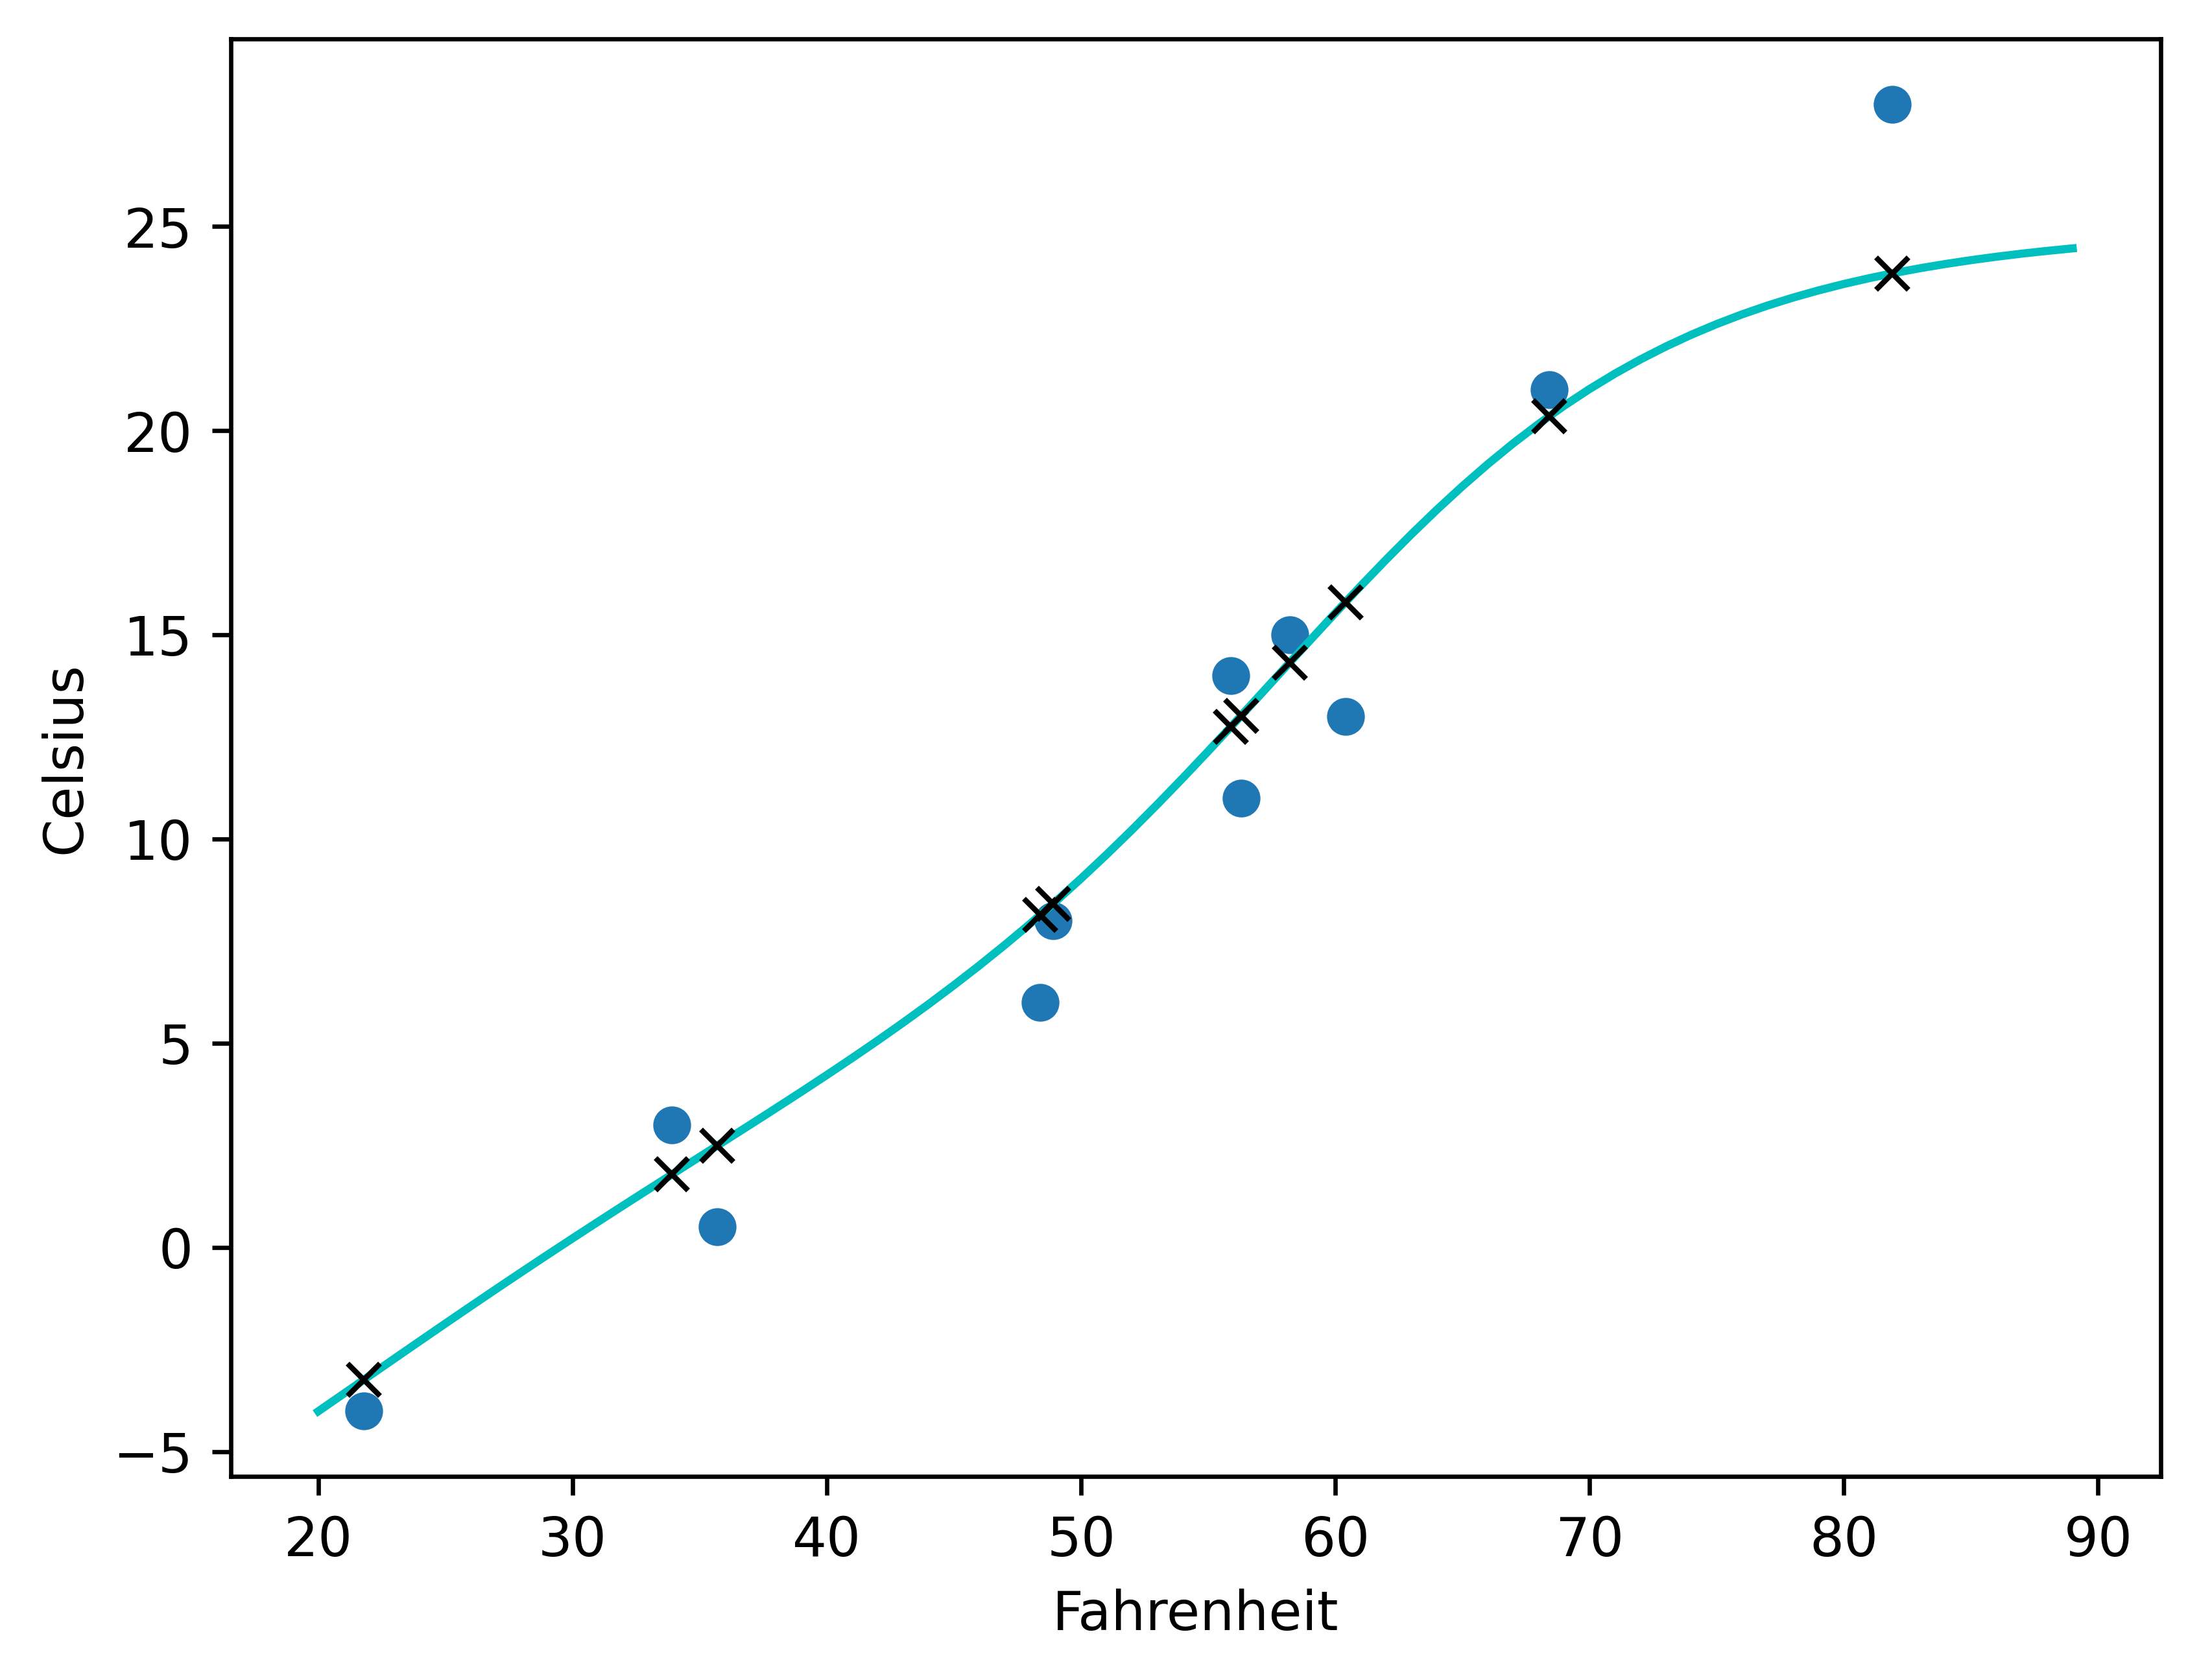

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Epoch 1, Training loss 142.4039, Validation loss 393.4069
Epoch 1000, Training loss 36.8237, Validation loss 185.3091
Epoch 2000, Training loss 29.3017, Validation loss 156.8598
Epoch 3000, Training loss 21.8181, Validation loss 131.2688
Epoch 4000, Training loss 15.8464, Validation loss 107.2149
Epoch 5000, Training loss 11.3705, Validation loss 87.4479


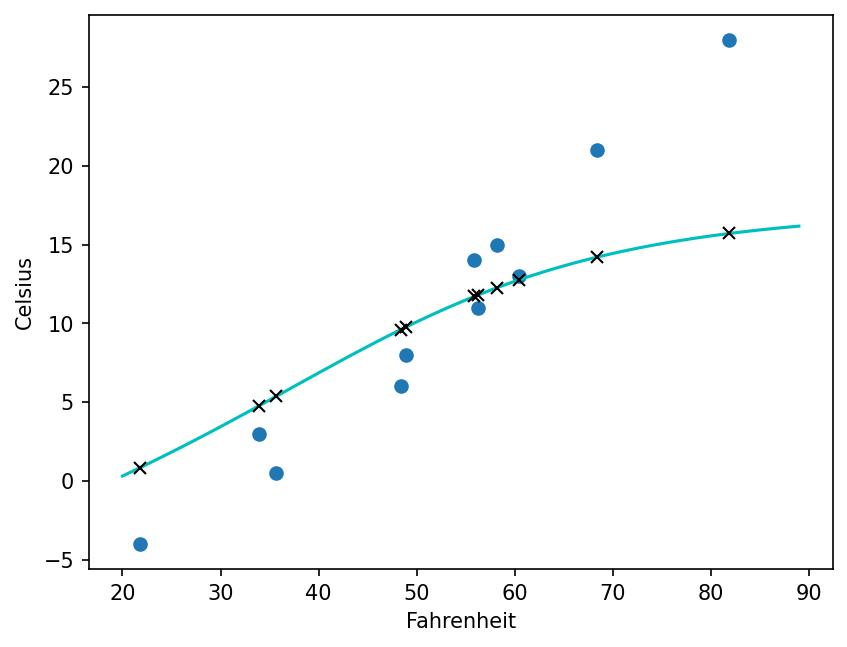

In [24]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')